# Test biaslyze with the toxic comments dataset

Data source: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/home/tobias/Repositories/biaslyze/')

In [3]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

## Load and prepare data

In [4]:
df = pd.read_csv("../data/jigsaw-toxic-comment-classification/train.csv"); df.sample(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
152166,88dfbc72fbba5276,Not bad; but I see a few questionable wording ...,0,0,0,0,0,0
64882,ada127fe75145256,"I agree. Merge. There should be a sentence, pa...",0,0,0,0,0,0
115044,67270fec3f3f1873,It is just as much garbage to claim that the y...,1,0,0,0,0,0
69151,b905508336d93b61,Commons nudity (category header),0,0,0,0,0,0
53601,8f507f0061c0c840,BTW: here's the complete sum total of your cre...,0,0,0,0,0,0
131285,be70bdcc35f87040,"POTD notification\n]]\nHi Tomer,\n\nJust to le...",0,0,0,0,0,0
54305,9118e63a16ac84b9,Flying on one x \nI notice that BillCJ rightly...,0,0,0,0,0,0
103159,280a4fb24616fb37,", as they look too unprofessional",0,0,0,0,0,0
159370,fc91c49055ade306,Wikipedia is not a mere collection of weblinks...,0,0,0,0,0,0
137309,dea5d51a4f50171a,"""\nI would be greatful if could explain how a...",0,0,0,0,0,0


In [5]:
# make the classification problem binary
df["target"] = df[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].sum(axis=1) > 0

In [6]:
df["target"].mean()

0.10167887648758234

## Train a BoW-model

In [7]:
clf = make_pipeline(TfidfVectorizer(min_df=10, max_features=30000, stop_words="english"), LogisticRegression(C=10))

In [8]:
clf.fit(df.comment_text, df.target)

/home/tobias/.cache/pypoetry/virtualenvs/biaslyze-OjqpgMw8-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=30000, min_df=10,
                                 stop_words='english')),
                ('logisticregression', LogisticRegression(C=10))])

In [9]:
train_pred = clf.predict(df.comment_text)
print(accuracy_score(df.target, train_pred))

0.9753589311341033


### probe the model a bit to see if we got an obvious problem

In [10]:
test_text = "Jews and muslims are great friends!"

print(clf.predict_proba([test_text]))

[[0.95867571 0.04132429]]


In [11]:
test_text = "That woman is great!"

print(clf.predict_proba([test_text]))

[[0.95762929 0.04237071]]


In [12]:
test_text = "That man is great!"

print(clf.predict_proba([test_text]))

[[0.96072211 0.03927789]]


In [104]:
test_text = "You are a mum."

print(clf.predict_proba([test_text]))

[[0.18205634 0.81794366]]


In [140]:
test_text = "I'm a mum from the usa."

print(clf.predict_proba([test_text]))

[[0.09550965 0.90449035]]


In [14]:
test_text = "My mother is a jew."

print(clf.predict_proba([test_text]))

[[0.17696407 0.82303593]]


### Look at the logistc regression coefficients

In [15]:
coef = clf.named_steps.get("logisticregression").coef_

In [16]:
vocab = clf.named_steps.get("tfidfvectorizer").vocabulary_

In [17]:
vocab_coef_dict = {token: coef[0][idx] for token, idx in vocab.items()}

In [18]:
dict(sorted(vocab_coef_dict.items(), key=lambda v: -v[1]))

{'fuck': 32.7837917280138,
 'fucking': 27.82425052783078,
 'idiot': 20.15266937256496,
 'shit': 20.013563243286278,
 'bitch': 18.475908925024964,
 'bullshit': 18.10295490046663,
 'ass': 18.077966939946386,
 'asshole': 17.57561292196972,
 'stupid': 16.622723488339,
 'suck': 16.11790605183115,
 'faggot': 15.378837213619931,
 'cunt': 14.868528007269816,
 'fucked': 13.81268406440718,
 'bastard': 13.281050718084172,
 'sucks': 13.276981732229888,
 'idiots': 13.246334105799505,
 'dick': 13.15745751086574,
 'moron': 12.716570056508065,
 'crap': 12.421849116680283,
 'idiotic': 12.05640679677976,
 'fucker': 11.918809872032933,
 'penis': 11.841626404913812,
 'cock': 11.75222203927742,
 'motherfucker': 11.679984445953181,
 'nigger': 11.417909656954315,
 'dumbass': 11.406342587802497,
 'jerk': 11.21120568622119,
 'pussy': 11.119175729917208,
 'dickhead': 10.554774339384167,
 'pathetic': 10.553991439145115,
 'faggots': 10.48665264384712,
 'assholes': 10.465908992082616,
 'fuckin': 10.34301322437423,

## Test LIME based bias detection with keywords

In [129]:
from biaslyze.evaluators import LimeBiasEvaluator
from biaslyze.bias_detectors import LimeKeywordBiasDetector

In [130]:
bias_detector = LimeKeywordBiasDetector(
    bias_evaluator=LimeBiasEvaluator(n_lime_samples=500),
    n_top_keywords=30,
    use_tokenizer=True
)

In [131]:
test_texts = df.comment_text.sample(500).tolist() #+ ["i humped jams mum"]
detection_res = bias_detector.detect(texts=test_texts, predict_func=clf.predict_proba)

2023-05-04 10:51:14.032 | INFO     | biaslyze.concept_detectors:detect:33 - Started keyword-based concept detection on 500 texts...
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 88.84it/s]
2023-05-04 10:51:19.665 | INFO     | biaslyze.concept_detectors:detect:49 - Done. Found 199 texts with protected concepts.
2023-05-04 10:51:19.666 | INFO     | biaslyze.evaluators:evaluate:45 - Started bias detection on 199 samples...
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 199/199 [01:28<00:00,  2.24it/s]


In [132]:
detection_res.summary()

Detected 147 samples with potential issues.
    Potentially problematic concepts detected: [('gender', 113), ('nationality', 44), ('religion', 9)]
    Based on keywords: [('he', 23), ('they', 17), ('them', 17), ('his', 14), ('their', 14), ('him', 13), ('guys', 6), ('her', 5), ('usa', 5), ('guy', 5), ('man', 4), ('she', 4), ('men', 4), ('japanese', 3), ('uk', 3), ('women', 3), ('iraq', 2), ('himself', 2), ('jewish', 2), ('american', 2)].


In [133]:
detection_res.details(group_by_concept=True)

Concept: gender
[{'reason': ['his', 'he'],
  'text': 'I am personally geneticist and Elhaik did not carry out any genetic '
          'study, so his article has no place in the section regarding actual '
          'genetic studies, because it is against all genetic studies (and all '
          'genetic studies refuted the Khazarian hypothesis which is '
          'considered both by historians and geneticists as falls. Basic '
          'WP:UNDUE rule. Considering Zoossmann-Diskin as a legitimate study '
          'it is mentioned, yet as his conclusions are backed by ratio 1:23 he '
          'does not go in repetition, lead or background again- Basic WP:UNDUE '
          'rule'},
 {'reason': ['his'],
  'text': 'i want to report man for blocking \n'
          '\n'
          'http://en.wikipedia.org/wiki/User:RolandR this man delete every '
          'thing that is not fit to his opinions even if it is true please '
          'block him.'},
 {'reason': ['his'],
  'text': '"\n'
        

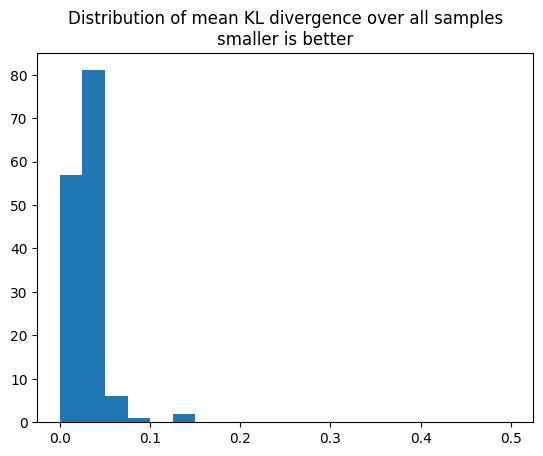

In [134]:
plt.hist([sample.metrics.get("mean_KL_divergence") for sample in detection_res.biased_samples], bins=20, range=[0,0.5])
plt.title("Distribution of mean KL divergence over all samples\nsmaller is better");

In [136]:
from bokeh.io import show, output_notebook

output_notebook()

dashboard = detection_res.dashboard()
show(dashboard)

Loading BokehJS ...

In [138]:
pos_dashboard = detection_res.dashboard(use_position=True)
show(pos_dashboard)

## Try to cluster detected biases

In [65]:
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer

In [66]:
# Prepare embeddings
docs = [sample.text for sample in detection_res.biased_samples]
y = [", ".join(sample.bias_concepts) for sample in detection_res.biased_samples]
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
vectorizer_model = CountVectorizer(stop_words="english")
embeddings = sentence_model.encode(docs, show_progress_bar=False)

hdbscan_model = HDBSCAN(min_cluster_size=5, metric='euclidean', cluster_selection_method='eom') #, max_cluster_size=25)
# Train BERTopic
topic_model = BERTopic(hdbscan_model=hdbscan_model, vectorizer_model=vectorizer_model).fit(docs, embeddings)

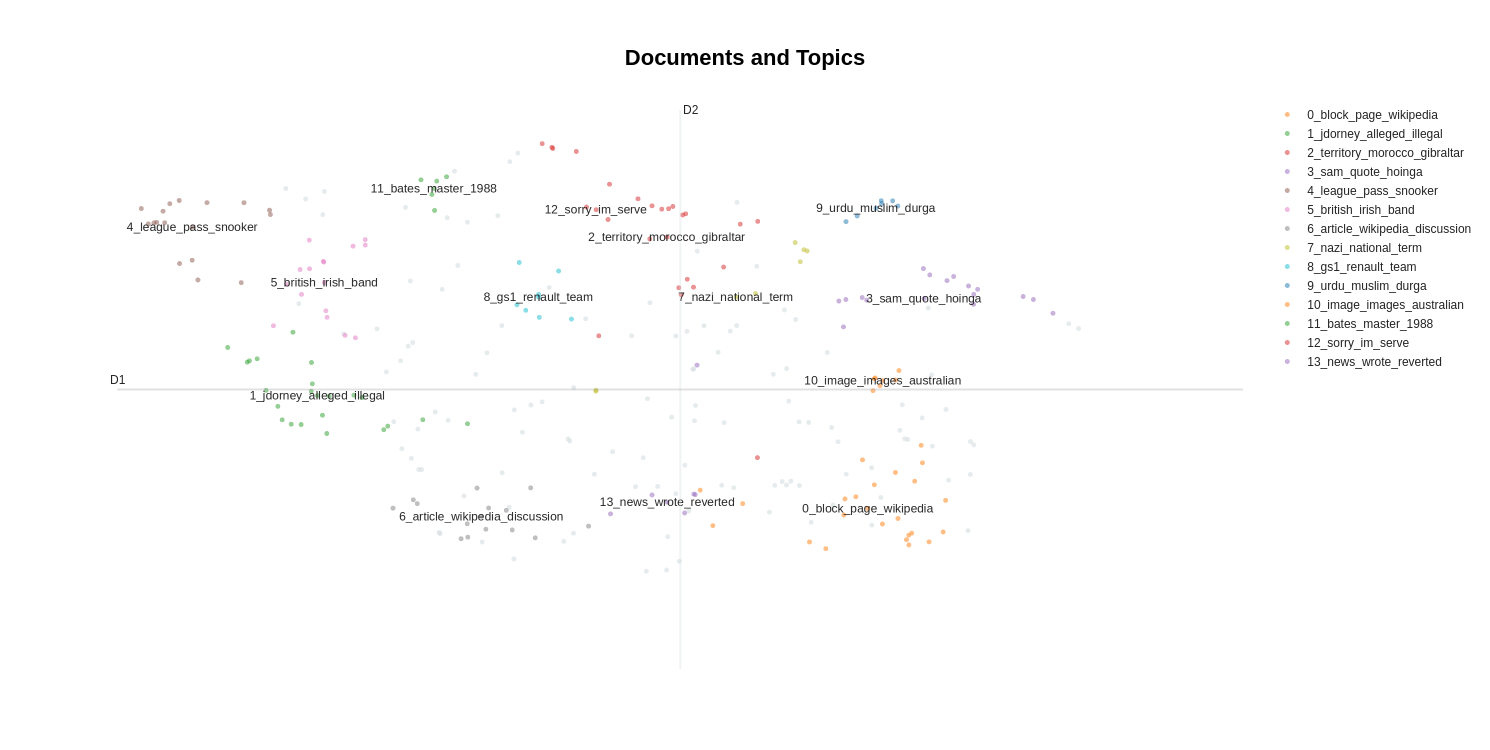

In [67]:
# Run the visualization with the original embeddings
topic_model.visualize_documents(docs, embeddings=embeddings)

# Reduce dimensionality of embeddings, this step is optional but much faster to perform iteratively:
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
topic_model.visualize_documents(docs, reduced_embeddings=reduced_embeddings)

In [68]:
topic_model.topic_labels_

{-1: '-1_article_just_page_like',
 0: '0_block_page_wikipedia_work',
 1: '1_jdorney_alleged_illegal_rove',
 2: '2_territory_morocco_gibraltar_countries',
 3: '3_sam_quote_hoinga_im',
 4: '4_league_pass_snooker_barnstar',
 5: '5_british_irish_band_woolwich',
 6: '6_article_wikipedia_discussion_ive',
 7: '7_nazi_national_term_use',
 8: '8_gs1_renault_team_blu',
 9: '9_urdu_muslim_durga_pakistan',
 10: '10_image_images_australian_racist',
 11: '11_bates_master_1988_disney',
 12: '12_sorry_im_serve_honorably',
 13: '13_news_wrote_reverted_just'}

In [70]:
import yaml
from bokeh.themes import Theme
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, Slider, TextInput, HoverTool
from bokeh.palettes import Spectral5, Accent5, Category10_10, Category20_20
from bokeh.io import curdoc
from bokeh.layouts import column, row


def bkapp(doc):
    hover_tool = HoverTool(tooltips=[("Text", "@text"), ("Keywords", "@keywords")])
    p = figure(width=1200, height=800, tools=["pan","wheel_zoom","box_zoom","reset", hover_tool])

    bias_concept = [",".join(sample.bias_concepts) for sample in detection_res.biased_samples]
    concept2int = list(set(bias_concept))
    num_bias_concept = [concept2int.index(c) for c in bias_concept]
    bias_intensity = [50*np.abs(sample.score) for sample in detection_res.biased_samples]

    # configure
    df = pd.DataFrame(dict(
        text=[sample.text for sample in detection_res.biased_samples],
        keywords=[",".join(sample.bias_reasons) for sample in detection_res.biased_samples],
        x=reduced_embeddings[:,0],
        y=reduced_embeddings[:,1],
        color=[Category20_20[idx] for idx in num_bias_concept],
        bias_intensity=bias_intensity,
        bias_concept=bias_concept,
    ))
    source = ColumnDataSource(data=df)

    # add a circle renderer with a size, color, and alpha
    p.scatter(
        "x", "y",
        source=source,
        color="color",
        size="bias_intensity",
        alpha=0.3,
        legend_group="bias_concept",
    )

    p.legend.location = "top_left"
    #p.legend.click_policy="hide"

    # slider
    threshold = Slider(title="threshold", value=0.0, start=0.0, end=1.0, step=0.01, width=750)

    def update_data(attrname, old, new):
        # Get the current slider values
        t = threshold.value
        new_df = df.copy()
        new_df["bias_intensity"] = new_df.bias_intensity.apply(lambda x: x if x >= 50*t else 0.0)
        source.data = new_df

    threshold.on_change('value', update_data)


    doc.add_root(column(threshold, p, width=800))
    # show the results
    doc.theme = Theme(json=yaml.load("""
        attrs:
            figure:
                background_fill_color: "#DDDDDD"
                outline_line_color: white
                toolbar_location: above
                height: 800
                width: 1200
            Grid:
                grid_line_dash: [6, 4]
                grid_line_color: white
    """, Loader=yaml.FullLoader))

show(bkapp)

## Testing a sentiment analysis model from huggingface

In [ ]:
from transformers import pipeline
from torch.utils.data import Dataset


classifier = pipeline(
    model="distilbert-base-uncased-finetuned-sst-2-english",
    top_k=None,
    padding=True,
    truncation=True
)

In [ ]:
class MyDataset(Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        return self.data[i]


def predict_sentiment(texts):
    data = MyDataset(texts)
    proba = []
    for res in classifier(data):
        proba_array = []
        for p in sorted(res, key=lambda d: d['label'], reverse=True):
            proba_array.append(p.get("score"))
        proba.append(np.array(proba_array))
    return np.array(proba) / np.array(proba).sum(axis=1)[:,None]

In [ ]:
bias_detector = LimeKeywordBiasDetector(
    bias_evaluator=LimeBiasEvaluator(n_lime_samples=500),
    n_top_keywords=10,
    use_tokenizer=True
)

In [ ]:
test_texts = df.comment_text.sample(50)
detection_res = bias_detector.detect(texts=test_texts, predict_func=predict_sentiment)

In [ ]:
detection_res.summary()

In [ ]:
detection_res.details(group_by_concept=True)

## !! Very Experimental !!: Test masked language model based bias detection with keywords

In [ ]:
from biaslyze.bias_detectors import MaskedKeywordBiasDetector
from biaslyze.concept_detectors import KeywordConceptDetector

In [ ]:
bias_detector = MaskedKeywordBiasDetector(n_resample_keywords=20, use_tokenizer=True)

In [ ]:
detection_res = bias_detector.detect(
    texts=df.comment_text.sample(1000),
    predict_func=clf.predict_proba
)

In [ ]:
detection_res.summary()

In [ ]:
detection_res.details()

In [ ]:
from bokeh.io import show, output_notebook

output_notebook()

dashboard = detection_res.dashboard()
show(dashboard)